# TPLS_example1.m

Written by Arthur 6/27/2022

This script shows how one can use T-PLS to build a whole-brain decoder. To see how to use T-PLS to assess CV performance, check example2.

## Loading the example data and package

We'll first load the data (also in the example directory)

In [85]:
# loading data
import scipy.io
TPLSdat = scipy.io.loadmat('TPLSdat.mat')
X = TPLSdat['X']; X.shape
Y = TPLSdat['Y']
run = TPLSdat['run']
subj = TPLSdat['subj']
mask = TPLSdat['mask']

This should load X, Y, run, subj, mask.

Mask is the 3d brain image mask, which is a 25-29-25 3D binary tensor.There are 3714 brain voxels in the mask

X is the single trial betas. It has 3714 columns, each of which corresponds to a voxel.

Y is binary variable to be predicted. In this case, the Y was whether the participant chose left or right button
Hopefully, when we create whole-brain predictor, we should be able to see left and right motor areas.

Subj is a numerical variable that tells us the subject number that each observation belongs to.
In this dataset, there are only 3 subjects.

Run is a numerical variable that tells us the scanner run that each observation belongs to.
In this dataset, each of the 3 subjects had 8 scan runs.

Next we'll load our TPLSp package as well as numpy

In [86]:
from TPLSp import TPLS, TPLS_cv, evalTuningParam # loading key functions
import numpy as np


## Doing cross-validation to identify tuning parameters

Let's first do leave-one-subject out cross-validation to find the best tuning parameters.
We will give X and Y as variables and subj to be used as cross-validation folds.
The rest of the inputs are omitted to default.

In [87]:
cvmdl = TPLS_cv(X,Y,subj)

Fold #1
Calculating Comp #1
Calculating Comp #2
Calculating Comp #3
Calculating Comp #4
Calculating Comp #5
Calculating Comp #6
Calculating Comp #7
Calculating Comp #8
Calculating Comp #9
Calculating Comp #10
Calculating Comp #11
Calculating Comp #12
Calculating Comp #13
Calculating Comp #14
Calculating Comp #15
Calculating Comp #16
Calculating Comp #17
Calculating Comp #18
Calculating Comp #19
Calculating Comp #20
Calculating Comp #21
Calculating Comp #22
Calculating Comp #23
Calculating Comp #24
Calculating Comp #25
Fold #2
Calculating Comp #1
Calculating Comp #2
Calculating Comp #3
Calculating Comp #4
Calculating Comp #5
Calculating Comp #6
Calculating Comp #7
Calculating Comp #8
Calculating Comp #9
Calculating Comp #10
Calculating Comp #11
Calculating Comp #12
Calculating Comp #13
Calculating Comp #14
Calculating Comp #15
Calculating Comp #16
Calculating Comp #17
Calculating Comp #18
Calculating Comp #19
Calculating Comp #20
Calculating Comp #21
Calculating Comp #22
Calculating Com

That should have been pretty quick.
Now we need to evaluate prediction performance across the three folds.
We will use AUC of ROC as the prediction performance metric.
By default we trained TPLS model with 25 components so we will try out 1 to 25 components in cross validation.
For thresholding, let's try 0 to 1 in 0.05 increments.

In [88]:
compvec = np.arange(25)+1
threshvec = np.arange(21)/20


Subfold is not always necessary but you can use it if you want your performance in each fold to be calculated by an average of subfolds rather than in whole. For example, in this case, instead of estimating the AUC across all 8 runs of each subject, we can estimate the AUC within each of the 8 runs and then average them to obtain subject-level performance metric. You may want to do this because there are often spurious baseline shifts in estimated activity across runs that can make their alignment poor.

In [89]:
subfold = run

Now let's evaluate the cross-validation performance and plot the tuning surface

Fold #1
Fold #2
Fold #3


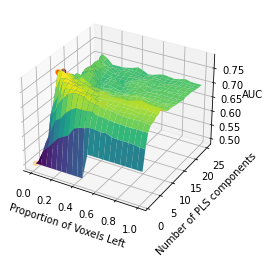

In [90]:
cvstats = evalTuningParam(cvmdl,'AUC',X,Y,compvec,threshvec,subfold);
cvstats.plot()

When you're doing this yourself, the plot should be an interactive 3D plot which you can rotate to see the surface.
Here, the best performance, as indicated by the blue dot (Max Perf) is at threshold 0.1 (10% of voxels left) and at 8 components. This information is also available in the evalTuningParam object you just created.

In [91]:
print(cvstats.perf_best)
print(cvstats.compval_best)
print(cvstats.threshval_best)

0.7774639425506024
8
0.1


## Building final model

Now that we know the best tuning parameter, let's fit the final model using this tuning parameter.
Fitting up to 25 components for simplicity. You can specify it to fit up to 8 components if you're short on time.

In [92]:
mdl = TPLS(X,Y)

Calculating Comp #1
Calculating Comp #2
Calculating Comp #3
Calculating Comp #4
Calculating Comp #5
Calculating Comp #6
Calculating Comp #7
Calculating Comp #8
Calculating Comp #9
Calculating Comp #10
Calculating Comp #11
Calculating Comp #12
Calculating Comp #13
Calculating Comp #14
Calculating Comp #15
Calculating Comp #16
Calculating Comp #17
Calculating Comp #18
Calculating Comp #19
Calculating Comp #20
Calculating Comp #21
Calculating Comp #22
Calculating Comp #23
Calculating Comp #24
Calculating Comp #25


See how much covariance between X and Y each PLS component explains and also the correlation between each PLS component and Y

In [93]:
print(np.hstack((mdl.pctVar,mdl.scoreCorr)))

[[0.09736926 0.31204047]
 [0.24144264 0.49136813]
 [0.11122752 0.33350791]
 [0.08636578 0.29388056]
 [0.04527602 0.21278162]
 [0.04477715 0.21160611]
 [0.05128454 0.2264609 ]
 [0.05368447 0.23169908]
 [0.04239729 0.20590601]
 [0.0405792  0.2014428 ]
 [0.03995722 0.19989303]
 [0.02770085 0.16643574]
 [0.02341608 0.15302314]
 [0.01442112 0.12008798]
 [0.01447517 0.1203128 ]
 [0.01348855 0.11614024]
 [0.00803255 0.08962447]
 [0.00891335 0.09441056]
 [0.00677065 0.08228397]
 [0.00522886 0.07231087]
 [0.00419221 0.06474725]
 [0.00366563 0.06054442]
 [0.00276652 0.05259773]
 [0.00265053 0.05148331]
 [0.00223107 0.04723422]]


Now let's extract the whole-brain map

In [94]:
compval = cvstats.compval_best
threshval = cvstats.threshval_best
betamap, intercept = mdl.makePredictor(compval,threshval)

Voila! you now have a whole-brain predictor. You can check how many voxels have non-zero coefficients by doing this:

In [95]:
sum(betamap != 0)

372

To me, it shows 372, which is about 1/10th of all the voxels (since that was our thresholding tuning parameter).

You can easily use this to predict trials by just multiplying this betamap to each single-trial beta images.

For example:

In [96]:
prediction = intercept + X @ betamap # the @ is a matrix multiplying operator
from scipy.stats import pearsonr
pearsonr(prediction.flatten(),Y.flatten()) # 0.63 correlation! In-sample though so not that impressive

(0.628157951901744, 1.4603714280975768e-77)

You can also use the built-in function for prediction as well

In [97]:
prediction = mdl.predict(compval,threshval,X)


## SHORT VERSION

In case you want a version of example that you can easily copy paste to your pipeline, here it is. 4 lines!

In [98]:
cvmdl = TPLS_cv(X,Y,subj)
cvstats = evalTuningParam(cvmdl,'AUC',X,Y, np.arange(25)+1, np.arange(21)/20, run)
mdl = TPLS(X,Y)
betamap = mdl.makePredictor(cvstats.compval_best,cvstats.threshval_best)

Fold #1
Calculating Comp #1
Calculating Comp #2
Calculating Comp #3
Calculating Comp #4
Calculating Comp #5
Calculating Comp #6
Calculating Comp #7
Calculating Comp #8
Calculating Comp #9
Calculating Comp #10
Calculating Comp #11
Calculating Comp #12
Calculating Comp #13
Calculating Comp #14
Calculating Comp #15
Calculating Comp #16
Calculating Comp #17
Calculating Comp #18
Calculating Comp #19
Calculating Comp #20
Calculating Comp #21
Calculating Comp #22
Calculating Comp #23
Calculating Comp #24
Calculating Comp #25
Fold #2
Calculating Comp #1
Calculating Comp #2
Calculating Comp #3
Calculating Comp #4
Calculating Comp #5
Calculating Comp #6
Calculating Comp #7
Calculating Comp #8
Calculating Comp #9
Calculating Comp #10
Calculating Comp #11
Calculating Comp #12
Calculating Comp #13
Calculating Comp #14
Calculating Comp #15
Calculating Comp #16
Calculating Comp #17
Calculating Comp #18
Calculating Comp #19
Calculating Comp #20
Calculating Comp #21
Calculating Comp #22
Calculating Com